In [11]:
:dep nsi = { path = "/Users/moritz/code/crates/nsi", features = ["jupyter"] }
:dep p_ops = { package = "polyhedron-ops", path = "/Users/moritz/code/crates/polyhedron-ops", features = [ "nsi" ] }

Create a rendering [context](https://docs.rs/nsi/latest/nsi/struct.Context.html).

In [12]:
let ctx = nsi::Context::new(&[]).unwrap();

The type of the variable polyhedron was redefined, so was lost.


Create a dodecahedron.

In [13]:
let polyhedron = p_ops::Polyhedron::dodecahedron();

We convert the dodecahedron into an NSI node and connect it to the scene’s root.

In [14]:
let handle = polyhedron.to_nsi(&ctx, None, None, None, None);
ctx.connect(handle.as_str(), "", ".root", "objects", &[]);

Set up an [attribute](https://nsi.readthedocs.io/en/latest/nodes.html#node-attributes) to hook up a shader to our geometry node.

We then create & connect a [shader](https://nsi.readthedocs.io/en/latest/nodes.html#the-shader-node) and instance a *principled* [OSL](https://opensource.imageworks.com/osl.html) shader.

In [32]:
ctx.create("dodeca_attrib", nsi::NodeType::Attributes, &[]);
ctx.connect("dodeca_attrib", "", handle.as_str(), "geometryattributes", &[]);

ctx.create("dodeca_shader", nsi::NodeType::Shader, &[]);
ctx.connect("dodeca_shader", "", "dodeca_attrib", "surfaceshader", &[]);

ctx.set_attribute(
    "dodeca_shader",
    &[
        nsi::string!("shaderfilename", "${DELIGHT}/osl/dlPrincipled"),
        nsi::color!("i_color", &[0.8, 0.5, 0.3]),
        nsi::float!("roughness", 0.1),
        nsi::float!("specular_level", 0.5),
        nsi::float!("metallic", 1.0),
    ],
);

Next we set up an [environment](https://nsi.readthedocs.io/en/latest/nodes.html#the-environment-node) node and instance an emissive *environment* [OSL](https://opensource.imageworks.com/osl.html) shader.

In [28]:
ctx.create("environment", nsi::NodeType::Environment, &[]);
ctx.connect("environment", "", ".root", "objects", &[]);

ctx.create("env_attrib", nsi::NodeType::Attributes, &[]);
ctx.connect("env_attrib", "", "environment", "geometryattributes", &[]);

ctx.set_attribute("env_attrib", &[nsi::integer!("visibility.camera", 0)]);

ctx.create("env_shader", nsi::NodeType::Shader, &[]);
ctx.connect("env_shader", "", "env_attrib", "surfaceshader", &[]);

ctx.set_attribute(
    "env_shader",
    &[
        nsi::string!(
            "shaderfilename",
            "${DELIGHT}/osl/environmentLight"
        ),
        nsi::float!("intensity", 1.5),
    ],
);

ctx.set_attribute(
    "env_shader",
    &[nsi::string!("image", "/Users/moritz/code/crates/nsi/assets/wooden_lounge_1k.tdl")],
);

And finally, a camera transform & a [camera](https://nsi.readthedocs.io/en/latest/nodes.html#camera-nodes).

In [36]:
ctx.create("camera_xform", nsi::NodeType::Transform, &[]);
ctx.connect("camera_xform", "", ".root", "objects", &[]);
ctx.set_attribute(
    "camera_xform",
    &[nsi::double_matrix!(
        "transformationmatrix",
        &[1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 5., 1.,]
    )],
);

ctx.create("camera", nsi::NodeType::PerspectiveCamera, &[]);
ctx.connect("camera", "", "camera_xform", "objects", &[]);
ctx.set_attribute("camera", &[nsi::float!("fov", 40.)]);

We hook up a [screen](https://nsi.readthedocs.io/en/latest/nodes.html#the-screen-node) to the camera set the resolution and the antialiasing samples.

We also adjust the shading quality for the whole scene on the [global](https://nsi.readthedocs.io/en/latest/nodes.html#the-global-node) node.

In [37]:
ctx.create("screen", nsi::NodeType::Screen, &[]);
ctx.connect("screen", "", "camera", "screens", &[]);
ctx.set_attribute(
    "screen",
    &[
        nsi::integers!("resolution", &[400, 400]).array_len(2),
        nsi::integer!("oversampling", 16),
    ],
);

ctx.set_attribute(
    ".global",
    &[
        nsi::integer!("quality.shadingsamples", 64),
    ],
);

And we’re ready to render the screen to our notebook.

3DL INFO Loaded "/Applications/3Delight/osl/environmentLight.oso" (took 0.00s)
3DL INFO Loaded "/Applications/3Delight/osl/dlPrincipled.oso" (took 0.01s)


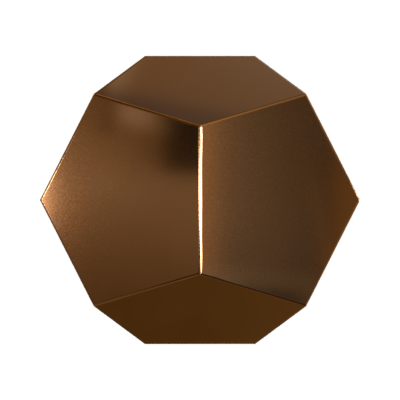

In [38]:
ctx.as_jupyter("screen");